In [4]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from eumap.misc import find_files, ttprint, nan_percentile, GoogleSheet
from eumap.raster import read_rasters, save_rasters
import warnings
import multiprocess as mp
import time
from scipy.special import expit, logit
import warnings
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, cross_val_score, HalvingGridSearchCV, KFold, GroupKFold, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error, median_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
import joblib
import pickle
from sklearn.metrics import r2_score, mean_squared_error, make_scorer#, root_mean_squared_error
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
# from cubist import Cubist
from sklearn.base import BaseEstimator, TransformerMixin
from pathlib import Path
import json
from benchmark_pipeline import read_features, run_cumusort, parameter_fine_tuning, evaluate_model, calc_ccc, separate_data
from scipy.stats import boxcox
from scipy.special import inv_boxcox
### input
folder = 'http://192.168.1.30:8333/ai4sh-landmasked/model_benchmark'
# from log_back_transform_rf import TreesRandomForestRegressor

prop_list = ['ocd','oc','bulk_density', 'ph_cacl2','ph_h2o','N','caco3','K','EC','P','CEC','texture1','texture2'] # unitl N everything has lightGBM models
space_list = ['log1p','log1p','normal', 'normal','normal','log1p','log1p','log1p','log1p','log1p','log1p','log1p','log1p'] # 
filt_list = [5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5] #5,5,5,5,

 ### obtain the metrics from CV

In [7]:

import warnings
warnings.filterwarnings('ignore')
n_trees = 64
pred = {}
results = []
for ii in [0]:#range(len(prop_list)):  #[11]:
    ttprint(f'processing {prop_list[ii]}')
    prop = prop_list[ii]
    # space = space_list[ii]
    output_folder = f'/home/opengeohub/xuemeng/work_xuemeng/soc/results_new/{prop}'
    tgt = f'{prop}_log1p'
    tgt2 = f'{prop}_boxcox'
    
    
    # features
    # cal = pd.read_csv(f'{output_folder}/benchmark_cal.pnts_{prop}.csv',low_memory=False)
    # covs = run_cumusort(cal, tgt, prop, output_folder) #, weights_feature=None, threshold_step=0.001
    # covs = read_features(f'/home/opengeohub/xuemeng/work_xuemeng/soc/results_new/{prop}/benchmark_selected.covs_{prop}.txt')
    covs = read_features(f'/home/opengeohub/xuemeng/work_xuemeng/soc/SOC-EU/features/001_covar_all.txt')
    
    # cross validation
    cal = pd.read_csv(f'{output_folder}/benchmark_cal.pnts_{prop}.csv',low_memory=False)
    cal = cal.dropna(subset=covs+[prop],how='any')
    cal[tgt] = np.log1p(cal[prop])
    cal[tgt2],fitted_lambda= boxcox(cal[prop],lmbda=None)
    
    rf = RandomForestRegressor(random_state=40, n_jobs=80, n_estimators=n_trees)
    
    cv = GroupKFold(n_splits=5)
    y_ori = cross_val_predict(rf, cal[covs], cal[prop], cv=cv, groups=cal['tile_id'], n_jobs=90)
    y_log = cross_val_predict(rf, cal[covs], cal[tgt], cv=cv, groups=cal['tile_id'], n_jobs=90)
    y_box = cross_val_predict(rf, cal[covs], cal[tgt2], cv=cv, groups=cal['tile_id'], n_jobs=90)
    
      
    results.append({
        'property': prop,
        'lambda': fitted_lambda,
        'MAE, model ori': mean_absolute_error(cal[prop],y_ori),
        'MAE, model log': mean_absolute_error(cal[prop],np.expm1(y_log)),
        'MAE, model boxcox': mean_absolute_error(cal[prop],inv_boxcox(y_box,fitted_lambda)),
        # 'MAE, model ori, in log': mean_absolute_error(cal[tgt],np.log1p(y_ori)),
        # 'MAE, model log, in log': mean_absolute_error(cal[tgt],y_log),
        
        'MedAE, model ori': median_absolute_error(cal[prop],y_ori),
        'MedAE, model log': median_absolute_error(cal[prop],np.expm1(y_log)),
        'MedAE, model boxcox': median_absolute_error(cal[prop],inv_boxcox(y_box,fitted_lambda)),
        
        'MAPE, model ori': mean_absolute_percentage_error(cal[prop],y_ori),
        'MAPE, model log': mean_absolute_percentage_error(cal[prop],np.expm1(y_log)),
        'MAPE, model boxcox': mean_absolute_percentage_error(cal[prop],inv_boxcox(y_box,fitted_lambda)),
        
        'CCC, model ori': calc_ccc(cal[prop],y_ori),
        'CCC, model log': calc_ccc(cal[prop],np.expm1(y_log)),
        'CCC, model boxcox': calc_ccc(cal[prop],inv_boxcox(y_box,fitted_lambda)),
        # 'CCC, model ori': calc_ccc(cal[tgt],np.log1p(y_ori)),
        # 'CCC, model log': calc_ccc(cal[tgt],y_log),
        # 'CCC, model boxcox': calc_ccc(cal[tgt],np.log1p(inv_boxcox(y_box,fitted_lambda))),
        
        'R2, model ori': r2_score(cal[prop],y_ori),
        'R2, model log': r2_score(cal[prop],np.expm1(y_log)),
        'R2, model boxcox': r2_score(cal[prop],inv_boxcox(y_box,fitted_lambda)),
        # 'R2, model ori': r2_score(cal[tgt],np.log1p(y_ori)),
        # 'R2, model log': r2_score(cal[tgt],y_log),
        # 'R2, model boxcox': r2_score(cal[tgt],np.log1p(inv_boxcox(y_box,fitted_lambda))),
        
        'bias, model ori': np.mean(y_ori-cal[prop]),
        'bias, model log': np.mean(np.expm1(y_log)-cal[prop]),
        'bias, model boxcox': np.mean(inv_boxcox(y_box,fitted_lambda)-cal[prop]),
        # 'bias, model ori, in log': np.mean(np.log1p(y_ori)-cal[tgt]),
        # 'bias, model log, in log': np.mean(y_log-cal[tgt]),
    })
    # print(results[-1])
    # print()
    
    pred[prop+'_ori'] = y_ori 
    pred[prop+'_log'] = y_log
    pred[prop+'_boxcox'] = y_box
    pred[f'{prop}_true'] = cal[prop].values
    
    
def convert_ndarray_to_list(d):
    if isinstance(d, dict):
        return {k: convert_ndarray_to_list(v) for k, v in d.items()}
    elif isinstance(d, list):
        return [convert_ndarray_to_list(v) for v in d]
    elif isinstance(d, np.ndarray):
        return d.tolist()
    else:
        return d
    
pred_converted = convert_ndarray_to_list(pred)

import json
with open('/home/opengeohub/xuemeng/work_xuemeng/soc/result_paper/pred_log.boxcox.ori.json', 'w') as file:
    json.dump(pred_converted, file, indent=4)

results = pd.DataFrame(results)
results.to_csv('/home/opengeohub/xuemeng/work_xuemeng/soc/result_paper/metrics_log.boxcox.ori.csv',index=False)
results

[13:21:17] processing ocd


,property,lambda,"MAE, model ori","MAE, model log","MAE, model boxcox","MedAE, model ori","MedAE, model log","MedAE, model boxcox","MAPE, model ori","MAPE, model log","MAPE, model boxcox","CCC, model ori","CCC, model log","CCC, model boxcox","R2, model ori","R2, model log","R2, model boxcox","bias, model ori","bias, model log","bias, model boxcox"
0,ocd,0.260318,9.966648,8.786355,8.890518,6.095242,4.444211,4.638684,1.011276,0.563043,0.602368,0.631708,0.613666,0.623123,0.441588,0.454993,0.461192,1.119673,-2.941129,-2.209743


In [14]:
ccl =[]
for cc in results.columns:
    if 'MAPE' in cc:
        ccl.append(cc)
        
results[ccl]

,"MAPE, model ori","MAPE, model log","MAPE, model boxcox"
0,1.011276,0.563043,0.602368


In [11]:
results = pd.read_csv('/home/opengeohub/xuemeng/work_xuemeng/soc/result_paper/metrics_log.boxcox.ori.csv')

In [18]:
results

,property,lambda,"MAE, model ori","MAE, model log","MAE, model boxcox","MedAE, model ori","MedAE, model log","MedAE, model boxcox","MAPE, model ori","MAPE, model log","MAPE, model boxcox","CCC, model ori","CCC, model log","CCC, model boxcox","R2, model ori","R2, model log","R2, model boxcox","bias, model ori","bias, model log","bias, model boxcox"
0,ocd,0.260318,9.966648,8.786355,8.890518,6.095242,4.444211,4.638684,1.011276,0.563043,0.602368,0.631708,0.613666,0.623123,0.441588,0.454993,0.461192,1.119673,-2.941129,-2.209743


### predictions, ori vs. log1p plot

In [15]:
prop = 'ocd'
file_path = '/home/opengeohub/xuemeng/work_xuemeng/soc/result_paper/pred_log.boxcox.ori.json'
with open(file_path, 'r') as file:
    pred = json.load(file)
    
fitted_lambda = results['lambda'][0]
pred['ocd_ori'] = np.array(pred['ocd_ori'])
pred['ocd_true'] = np.array(pred['ocd_true'])
pred['ocd_boxcox'] = np.array(pred['ocd_boxcox'])

pred['ocd_log1p_ori'] = np.expm1(pred['ocd_log'])
pred['ocd_boxcox_ori'] = inv_boxcox(pred['ocd_boxcox'],fitted_lambda) 

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import boxcox

mae_ori = results.loc[results['property']==prop, 'MAE, model ori'].values[0]
medae_ori = results.loc[results['property']==prop, 'MedAE, model ori'].values[0]
mape_ori = results.loc[results['property']==prop, 'MAPE, model ori'].values[0]
ccc_ori = results.loc[results['property']==prop, 'CCC, model ori'].values[0]
r2_ori = results.loc[results['property']==prop, 'R2, model ori'].values[0]
bias_ori = results.loc[results['property']==prop, 'bias, model ori'].values[0]

mae_log1p = results.loc[results['property']==prop, 'MAE, model log'].values[0]
medae_log1p = results.loc[results['property']==prop, 'MedAE, model log'].values[0]
mape_log1p = results.loc[results['property']==prop, 'MAPE, model log'].values[0]
ccc_log1p = results.loc[results['property']==prop, 'CCC, model log'].values[0]
r2_log1p = results.loc[results['property']==prop, 'R2, model log'].values[0]
bias_log1p = results.loc[results['property']==prop, 'bias, model log'].values[0]

mae_boxcox = results.loc[results['property']==prop, 'MAE, model boxcox'].values[0]
medae_boxcox = results.loc[results['property']==prop, 'MedAE, model boxcox'].values[0]
mape_boxcox = results.loc[results['property']==prop, 'MAPE, model boxcox'].values[0]
ccc_boxcox = results.loc[results['property']==prop, 'CCC, model boxcox'].values[0]
r2_boxcox = results.loc[results['property']==prop, 'R2, model boxcox'].values[0]
bias_boxcox = results.loc[results['property']==prop, 'bias, model boxcox'].values[0]

# Data transformations
data_ori = pred['ocd_true']
data_log1p = np.log1p(pred['ocd_true'])
data_boxcox, adjusted_lambda = boxcox(pred['ocd_true'],lmbda=None)  # Small offset to avoid issues with zero values


from scipy.stats import binned_statistic
def fit_boundary_lines_and_fill(x, y, ax, n_bins=20, x_fit_range=(0, 30), x_plot_range=(0, 100)):
    mask = (x >= x_fit_range[0]) & (x <= x_fit_range[1])
    x_filtered = x[mask]
    y_filtered = y[mask]
    bin_means, bin_edges, _ = binned_statistic(x_filtered, y_filtered, statistic='mean', bins=n_bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_upper = binned_statistic(x_filtered, y_filtered, statistic=lambda y: np.percentile(y, 99), bins=n_bins)[0]
    bin_lower = binned_statistic(x_filtered, y_filtered, statistic=lambda y: np.percentile(y, 1), bins=n_bins)[0]
    upper_fit = np.polyfit(bin_centers[~np.isnan(bin_upper)], bin_upper[~np.isnan(bin_upper)], 1)
    lower_fit = np.polyfit(bin_centers[~np.isnan(bin_lower)], bin_lower[~np.isnan(bin_lower)], 1)
    x_fit = np.linspace(x_plot_range[0], x_plot_range[1], 500)
    upper_curve = np.polyval(upper_fit, x_fit)
    lower_curve = np.polyval(lower_fit, x_fit)
    ax.fill_between(x_fit, lower_curve, upper_curve, color='orange', alpha=0.2)
    ax.plot(x_fit, upper_curve, color='blue', linestyle='--', linewidth=2)
    ax.plot(x_fit, lower_curve, color='blue', linestyle='--', linewidth=2)

/tmp/ipykernel_1632/2351498609.py:102: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to make room for the colorbars


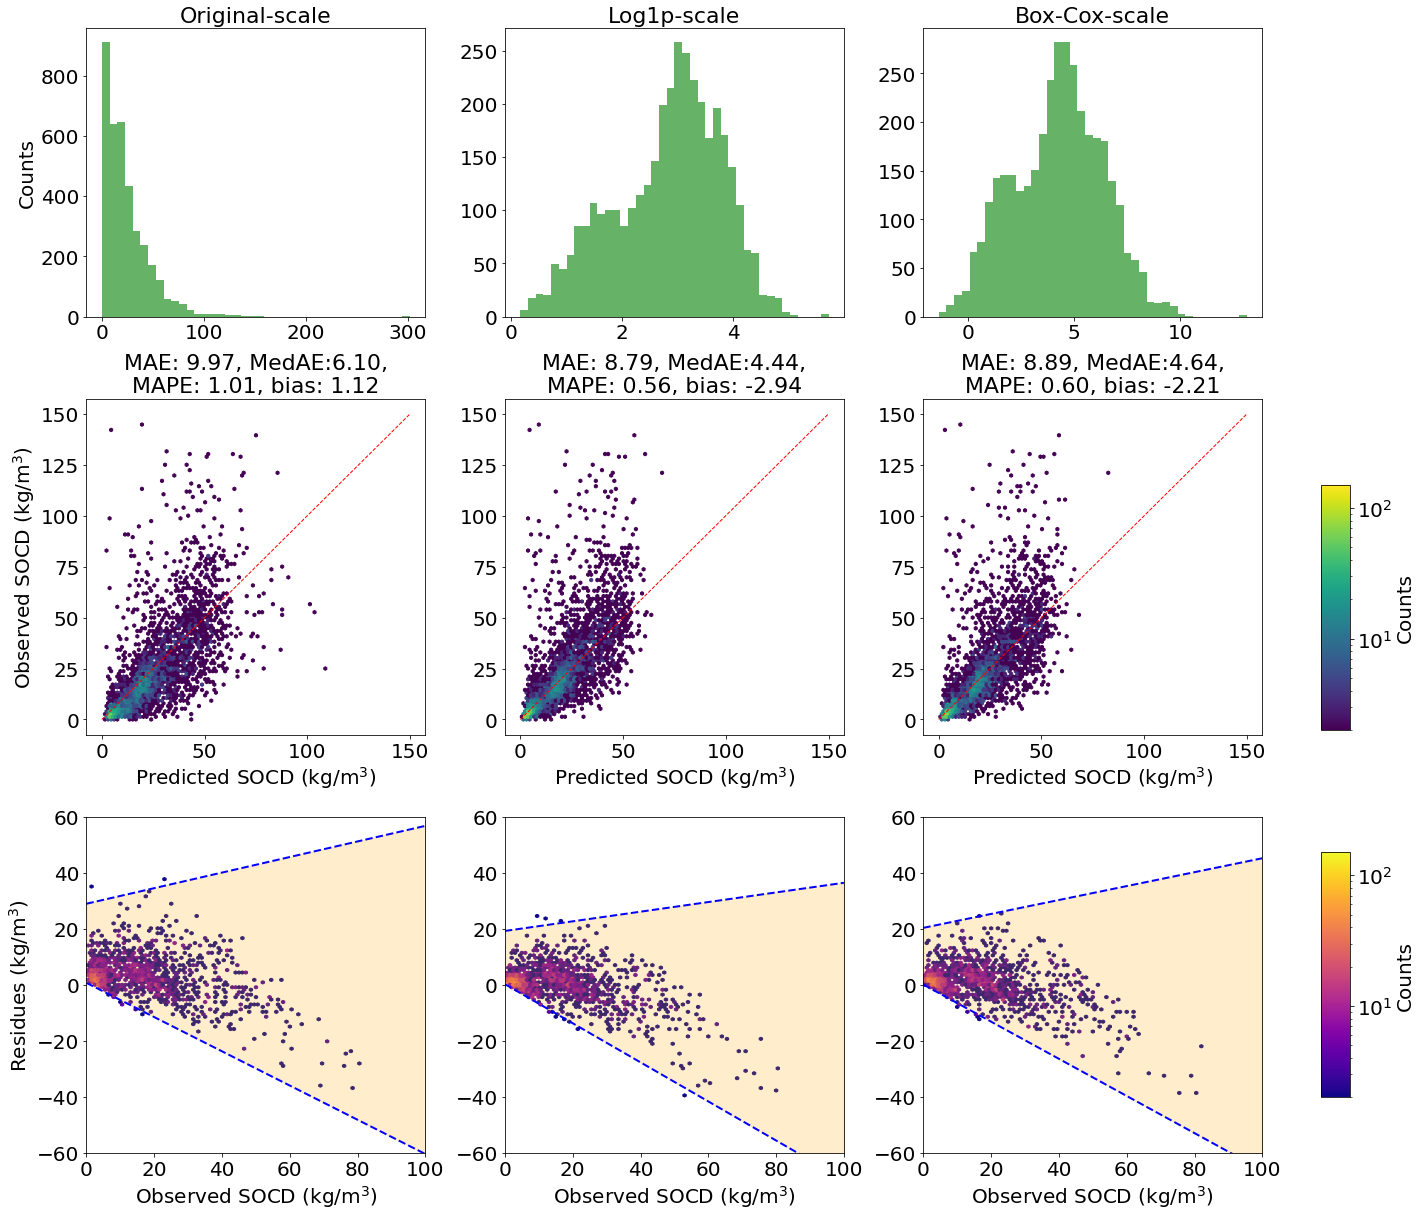

In [19]:

fig, axs = plt.subplots(3, 3, figsize=(20, 17), gridspec_kw={'height_ratios': [0.9, 1.05, 1.05]})

# Row 1: Share y-labels only (manually set the ticks and labels)
# axs[0, 1].sharey(axs[0, 0])
# axs[0, 2].sharey(axs[0, 0])
# Row 2 and 3: Share both y-axis and y-labels
axs[1, 1].sharey(axs[1, 0])
axs[1, 2].sharey(axs[1, 0])
axs[2, 1].sharey(axs[2, 0])
axs[2, 2].sharey(axs[2, 0])

# Plot histograms of the original data, log1p-transformed data, and Box-Cox-transformed data
axs[0, 0].hist(data_ori, bins=40, density=False, alpha=0.6, color='g')
axs[0, 0].set_title('Original-scale', fontsize=22)
axs[0, 0].set_ylabel('Counts', fontsize=20)
axs[0, 0].tick_params(axis='both', labelsize=20)

axs[0, 1].hist(data_log1p, bins=40, density=False, alpha=0.6, color='g')
axs[0, 1].set_title('Log1p-scale', fontsize=22)
axs[0, 1].tick_params(axis='both', labelsize=20)

axs[0, 2].hist(data_boxcox, bins=40, density=False, alpha=0.6, color='g')
axs[0, 2].set_title('Box-Cox-scale', fontsize=22)
axs[0, 2].tick_params(axis='both', labelsize=20)


# Predictions
x_min, x_max = 0, 150
y_min, y_max = 0, 150

# Determine global color map limits for hexbin plots in row 1
vmin = 2 #min(np.min(pred['ocd_ori']), np.min(pred['ocd_log1p_ori']), np.min(pred['ocd_boxcox_ori']))
vmax = 150 # max(np.max(pred['ocd_ori']), np.max(pred['ocd_log1p_ori']), np.max(pred['ocd_boxcox_ori']))

# Original-scale model
hb1 = axs[1, 0].hexbin(pred['ocd_ori'], pred['ocd_true'], gridsize=100, mincnt=1, extent=[x_min, x_max, y_min, y_max], bins='log', vmin=vmin, vmax=vmax)
axs[1, 0].set_title(f'MAE: {mae_ori:.2f}, MedAE:{medae_ori:.2f},\nMAPE: {mape_ori:.2f}, bias: {bias_ori:.2f}', fontsize=22) #, CCC: {ccc_ori:.2f}
axs[1, 0].set_ylabel('Observed SOCD (kg/m$^3$)', fontsize=20)
axs[1, 0].set_xlabel('Predicted SOCD (kg/m$^3$)', fontsize=20)
axs[1, 0].plot([x_min, x_max], [y_min, y_max], color='red', linestyle='--', linewidth=1)  # 1:1 line
axs[1, 0].tick_params(axis='both', labelsize=20)

# Log1p-scale model
hb2 = axs[1, 1].hexbin(pred['ocd_log1p_ori'], pred['ocd_true'], gridsize=100, mincnt=1, extent=[x_min, x_max, y_min, y_max], bins='log', vmin=vmin, vmax=vmax)
axs[1, 1].set_title(f'MAE: {mae_log1p:.2f}, MedAE:{medae_log1p:.2f},\nMAPE: {mape_log1p:.2f}, bias: {bias_log1p:.2f}', fontsize=22) #, CCC: {ccc_log1p:.2f}
axs[1, 1].set_xlabel('Predicted SOCD (kg/m$^3$)', fontsize=20)
axs[1, 1].plot([x_min, x_max], [y_min, y_max], color='red', linestyle='--', linewidth=1)  # 1:1 line
axs[1, 1].tick_params(axis='both', labelsize=20)

# Boxcox-scale model
hb3 = axs[1, 2].hexbin(pred['ocd_boxcox_ori'], pred['ocd_true'], gridsize=100, mincnt=1, extent=[x_min, x_max, y_min, y_max], bins='log', vmin=vmin, vmax=vmax)
axs[1, 2].set_title(f'MAE: {mae_boxcox:.2f}, MedAE:{medae_boxcox:.2f},\nMAPE: {mape_boxcox:.2f}, bias: {bias_boxcox:.2f}', fontsize=22) #, CCC: {ccc_boxcox:.2f}
axs[1, 2].set_xlabel('Predicted SOCD (kg/m$^3$)', fontsize=20)
axs[1, 2].plot([x_min, x_max], [y_min, y_max], color='red', linestyle='--', linewidth=1)  # 1:1 line
axs[1, 2].tick_params(axis='both', labelsize=20)

# Single colorbar for all hexbin plots in the second row
cbar_ax = fig.add_axes([0.92, 0.4, 0.02, 0.2])
cb = fig.colorbar(hb1, cax=cbar_ax)
cb.set_label('Counts', fontsize=20)
cb.ax.tick_params(labelsize=20)

# Residuals
x_min, x_max = 0, 100
y_min, y_max = -50, 50

# Original-scale residuals
residual_ori = pred['ocd_ori'] - pred['ocd_true']
hb4 = axs[2, 0].hexbin(pred['ocd_true'], residual_ori, gridsize=100, mincnt=2, bins='log', extent=[x_min, x_max, y_min, y_max], cmap='plasma', vmin=vmin, vmax=vmax)
axs[2, 0].set_xlabel('Observed SOCD (kg/m$^3$)', fontsize=20)
axs[2, 0].set_ylabel('Residues (kg/m$^3$)', fontsize=20)
axs[2, 0].tick_params(axis='both', labelsize=20)
axs[2, 0].set_xlim([0, 100])
axs[2, 0].set_ylim([-60, 60])
fit_boundary_lines_and_fill(pred['ocd_true'], residual_ori, axs[2, 0], x_fit_range=(0, 30), x_plot_range=(0, 100))

# Log1p-scale residuals
residual_log = pred['ocd_log1p_ori'] - pred['ocd_true']
hb5 = axs[2, 1].hexbin(pred['ocd_true'], residual_log, gridsize=100, mincnt=2, bins='log', extent=[x_min, x_max, y_min, y_max], cmap='plasma', vmin=vmin, vmax=vmax)
axs[2, 1].set_xlabel('Observed SOCD (kg/m$^3$)', fontsize=20)
axs[2, 1].tick_params(axis='both', labelsize=20)
axs[2, 1].set_xlim([0, 100])
axs[2, 1].set_ylim([-60, 60])
fit_boundary_lines_and_fill(pred['ocd_true'], residual_log, axs[2, 1], x_fit_range=(0, 30), x_plot_range=(0, 100))

# Boxcox-scale residuals
residual_boxcox = pred['ocd_boxcox_ori'] - pred['ocd_true']
hb6 = axs[2, 2].hexbin(pred['ocd_true'], residual_boxcox, gridsize=100, mincnt=2, bins='log', extent=[x_min, x_max, y_min, y_max], cmap='plasma', vmin=vmin, vmax=vmax)
axs[2, 2].set_xlabel('Observed SOCD (kg/m$^3$)', fontsize=20)
axs[2, 2].tick_params(axis='both', labelsize=20)
axs[2, 2].set_xlim([0, 100])
axs[2, 2].set_ylim([-60, 60])
fit_boundary_lines_and_fill(pred['ocd_true'], residual_boxcox, axs[2, 2], x_fit_range=(0, 30), x_plot_range=(0, 100))

# Single colorbar for all hexbin plots in the third row
cbar_ax_residual = fig.add_axes([0.92, 0.1, 0.02, 0.2])
cb_residual = fig.colorbar(hb4, cax=cbar_ax_residual)
cb_residual.set_label('Counts', fontsize=20)
cb_residual.ax.tick_params(labelsize=20)

# Adjust layout and save plot
plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to make room for the colorbars
plt.savefig('/home/opengeohub/xuemeng/work_xuemeng/soc/result_paper/plot_predictions_boxcox_log1p_ori_hist.pdf', dpi=300)
plt.show()


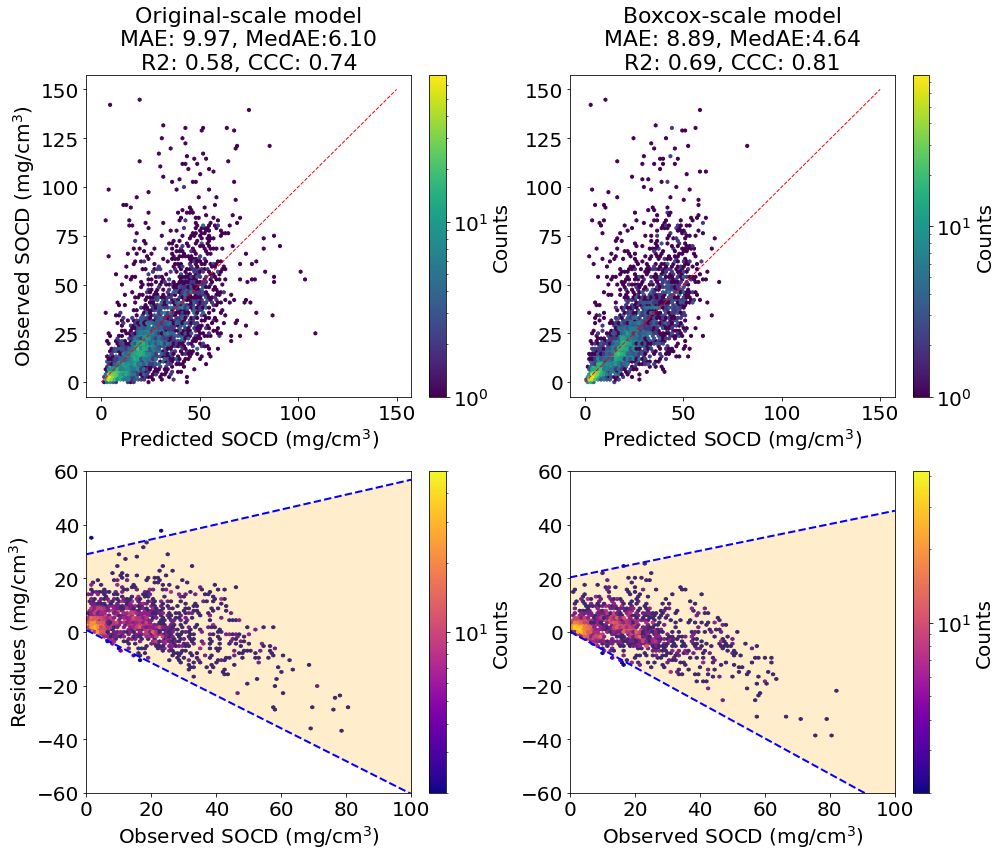

In [7]:
mae_ori = results.loc[results['property']==prop, 'MAE, model ori'].values[0]
medae_ori = results.loc[results['property']==prop, 'MdAE, model ori'].values[0]
ccc_ori = results.loc[results['property']==prop, 'CCC, model ori'].values[0]
r2_ori = results.loc[results['property']==prop, 'R2, model ori'].values[0]

mae_log1p = results.loc[results['property']==prop, 'MAE, model log'].values[0]
medae_log1p = results.loc[results['property']==prop, 'MdAE, model log'].values[0]
ccc_log1p = results.loc[results['property']==prop, 'CCC, model log'].values[0]
r2_log1p = results.loc[results['property']==prop, 'R2, model log'].values[0]

mae_boxcox = results.loc[results['property']==prop, 'MAE, model boxcox'].values[0]
medae_boxcox = results.loc[results['property']==prop, 'MdAE, model boxcox'].values[0]
ccc_boxcox = results.loc[results['property']==prop, 'CCC, model boxcox'].values[0]
r2_boxcox = results.loc[results['property']==prop, 'R2, model boxcox'].values[0]

from scipy.stats import binned_statistic
def fit_boundary_lines_and_fill(x, y, ax, n_bins=20, x_fit_range=(0, 30), x_plot_range=(0, 100)):
    mask = (x >= x_fit_range[0]) & (x <= x_fit_range[1])
    x_filtered = x[mask]
    y_filtered = y[mask]
    bin_means, bin_edges, _ = binned_statistic(x_filtered, y_filtered, statistic='mean', bins=n_bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_upper = binned_statistic(x_filtered, y_filtered, statistic=lambda y: np.percentile(y, 99), bins=n_bins)[0]
    bin_lower = binned_statistic(x_filtered, y_filtered, statistic=lambda y: np.percentile(y, 1), bins=n_bins)[0]
    upper_fit = np.polyfit(bin_centers[~np.isnan(bin_upper)], bin_upper[~np.isnan(bin_upper)], 1)
    lower_fit = np.polyfit(bin_centers[~np.isnan(bin_lower)], bin_lower[~np.isnan(bin_lower)], 1)
    x_fit = np.linspace(x_plot_range[0], x_plot_range[1], 500)
    upper_curve = np.polyval(upper_fit, x_fit)
    lower_curve = np.polyval(lower_fit, x_fit)
    ax.fill_between(x_fit, lower_curve, upper_curve, color='orange', alpha=0.2)
    ax.plot(x_fit, upper_curve, color='blue', linestyle='--', linewidth=2)
    ax.plot(x_fit, lower_curve, color='blue', linestyle='--', linewidth=2)

# Create figure and subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 12)) #, gridspec_kw={'height_ratios': [1.05, 0.95]}

# Predictions
x_min, x_max = 0, 150
y_min, y_max = 0, 150
hb1 = axs[0, 0].hexbin(pred['ocd_ori'], pred['ocd_true'], gridsize=100, mincnt=1, extent=[x_min, x_max, y_min, y_max], bins='log')
axs[0, 0].set_title(f'Original-scale model\nMAE: {mae_ori:.2f}, MedAE:{medae_ori:.2f}\nR2: {r2_ori:.2f}, CCC: {ccc_ori:.2f}', fontsize=22)
axs[0, 0].set_ylabel('Observed SOCD (mg/cm$^3$)', fontsize=20)
axs[0, 0].set_xlabel('Predicted SOCD (mg/cm$^3$)', fontsize=20)
axs[0, 0].plot([x_min, x_max], [y_min, y_max], color='red', linestyle='--', linewidth=1)  # 1:1 line
axs[0, 0].tick_params(axis='both', labelsize=20)

hb2 = axs[0, 1].hexbin(pred['ocd_boxcox_ori'], pred['ocd_true'], gridsize=100, mincnt=1, extent=[x_min, x_max, y_min, y_max], bins='log')
axs[0, 1].set_title(f'Boxcox-scale model\nMAE: {mae_boxcox:.2f}, MedAE:{medae_boxcox:.2f}\nR2: {r2_boxcox:.2f}, CCC: {ccc_boxcox:.2f}', fontsize=22)
axs[0, 1].set_xlabel('Predicted SOCD (mg/cm$^3$)', fontsize=20)
axs[0, 1].plot([x_min, x_max], [y_min, y_max], color='red', linestyle='--', linewidth=1)  # 1:1 line
axs[0, 1].tick_params(axis='both', labelsize=20)

cb1 = fig.colorbar(hb1, ax=axs[0, 0], location='right', fraction=0.05)
cb1.set_label('Counts', fontsize=20)
cb1.ax.tick_params(labelsize=20)

cb2 = fig.colorbar(hb2, ax=axs[0, 1], location='right', fraction=0.05)
cb2.set_label('Counts', fontsize=20)
cb2.ax.tick_params(labelsize=20)

# Residuals
x_min, x_max = 0, 100
y_min, y_max = -50, 50
residual_ori = pred['ocd_ori'] - pred['ocd_true']
hb3 = axs[1, 0].hexbin(pred['ocd_true'], residual_ori, gridsize=100, mincnt=2, bins='log', extent=[x_min, x_max, y_min, y_max], cmap='plasma', vmax=50)
axs[1, 0].set_xlabel('Observed SOCD (mg/cm$^3$)', fontsize=20)
axs[1, 0].set_ylabel('Residues (mg/cm$^3$)', fontsize=20)
axs[1, 0].tick_params(axis='both', labelsize=20)
axs[1, 0].set_xlim([0,100])
axs[1, 0].set_ylim([-60,60])
cb3 = fig.colorbar(hb3, ax=axs[1, 0], location='right', fraction=0.05)
cb3.set_label('Counts', fontsize=20)
cb3.ax.tick_params(labelsize=20)
fit_boundary_lines_and_fill(pred['ocd_true'], residual_ori, axs[1, 0], x_fit_range=(0, 30), x_plot_range=(0, 100))

residual_log = pred['ocd_boxcox_ori'] - pred['ocd_true']
hb4 = axs[1, 1].hexbin(pred['ocd_true'], residual_log, gridsize=100, mincnt=2, bins='log', extent=[x_min, x_max, y_min, y_max], cmap='plasma')
axs[1, 1].set_xlabel('Observed SOCD (mg/cm$^3$)', fontsize=20)
axs[1, 1].tick_params(axis='both', labelsize=20)
axs[1, 1].set_xlim([0,100])
axs[1, 1].set_ylim([-60,60])
cb4 = fig.colorbar(hb4, ax=axs[1, 1], location='right', fraction=0.05)
cb4.set_label('Counts', fontsize=20)
cb4.ax.tick_params(labelsize=20)
fit_boundary_lines_and_fill(pred['ocd_true'], residual_log, axs[1, 1], x_fit_range=(0, 30), x_plot_range=(0, 100))

# Adjust layout and save plot
plt.tight_layout()
plt.savefig('/home/opengeohub/xuemeng/work_xuemeng/soc/result_paper/plot_predictions_boxcox.ori.pdf', dpi=300)
plt.show()

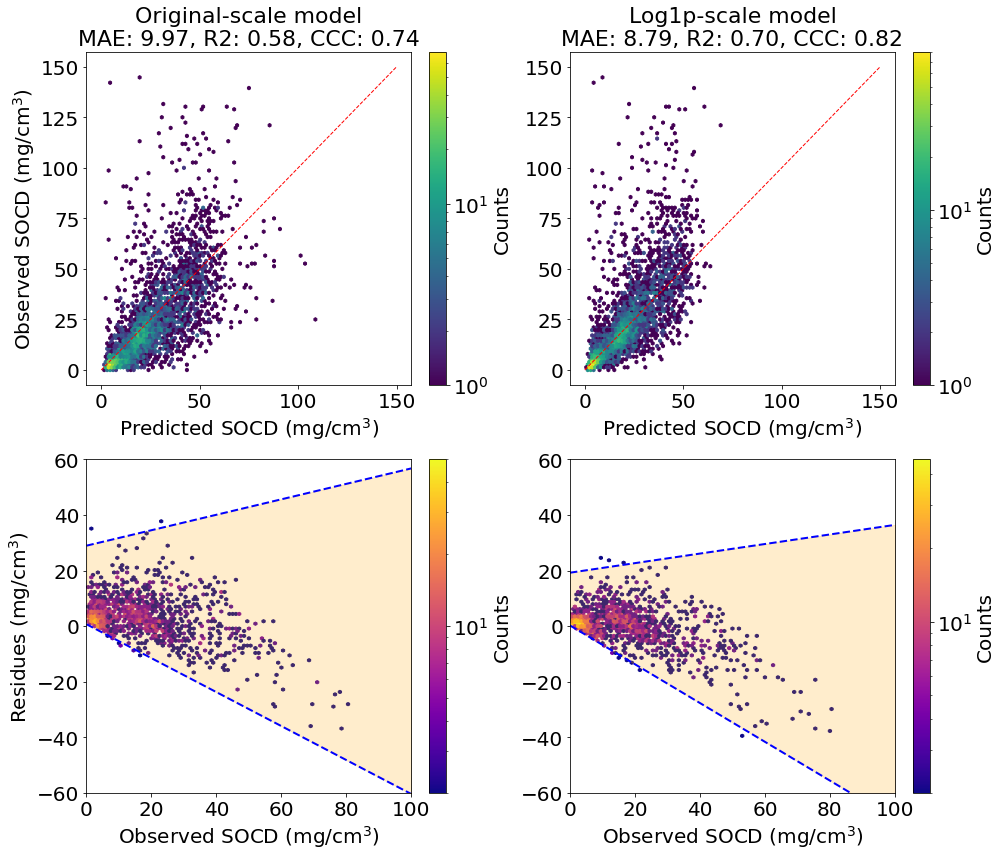

In [3]:
from scipy.stats import binned_statistic
def fit_boundary_lines_and_fill(x, y, ax, n_bins=20, x_fit_range=(0, 30), x_plot_range=(0, 100)):
    mask = (x >= x_fit_range[0]) & (x <= x_fit_range[1])
    x_filtered = x[mask]
    y_filtered = y[mask]
    bin_means, bin_edges, _ = binned_statistic(x_filtered, y_filtered, statistic='mean', bins=n_bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_upper = binned_statistic(x_filtered, y_filtered, statistic=lambda y: np.percentile(y, 99), bins=n_bins)[0]
    bin_lower = binned_statistic(x_filtered, y_filtered, statistic=lambda y: np.percentile(y, 1), bins=n_bins)[0]
    upper_fit = np.polyfit(bin_centers[~np.isnan(bin_upper)], bin_upper[~np.isnan(bin_upper)], 1)
    lower_fit = np.polyfit(bin_centers[~np.isnan(bin_lower)], bin_lower[~np.isnan(bin_lower)], 1)
    x_fit = np.linspace(x_plot_range[0], x_plot_range[1], 500)
    upper_curve = np.polyval(upper_fit, x_fit)
    lower_curve = np.polyval(lower_fit, x_fit)
    ax.fill_between(x_fit, lower_curve, upper_curve, color='orange', alpha=0.2)
    ax.plot(x_fit, upper_curve, color='blue', linestyle='--', linewidth=2)
    ax.plot(x_fit, lower_curve, color='blue', linestyle='--', linewidth=2)

# Create figure and subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 12)) #, gridspec_kw={'height_ratios': [1.05, 0.95]}

# Predictions
x_min, x_max = 0, 150
y_min, y_max = 0, 150
hb1 = axs[0, 0].hexbin(pred['ocd_ori'], pred['ocd_true'], gridsize=100, mincnt=1, extent=[x_min, x_max, y_min, y_max], bins='log')
axs[0, 0].set_title('Original-scale model\nMAE: 9.97, R2: 0.58, CCC: 0.74', fontsize=22)
axs[0, 0].set_ylabel('Observed SOCD (mg/cm$^3$)', fontsize=20)
axs[0, 0].set_xlabel('Predicted SOCD (mg/cm$^3$)', fontsize=20)
axs[0, 0].plot([x_min, x_max], [y_min, y_max], color='red', linestyle='--', linewidth=1)  # 1:1 line
axs[0, 0].tick_params(axis='both', labelsize=20)

hb2 = axs[0, 1].hexbin(pred['ocd_log_exp'], pred['ocd_true'], gridsize=100, mincnt=1, extent=[x_min, x_max, y_min, y_max], bins='log')
axs[0, 1].set_title('Log1p-scale model\nMAE: 8.79, R2: 0.70, CCC: 0.82', fontsize=22)
axs[0, 1].set_xlabel('Predicted SOCD (mg/cm$^3$)', fontsize=20)
axs[0, 1].plot([x_min, x_max], [y_min, y_max], color='red', linestyle='--', linewidth=1)  # 1:1 line
axs[0, 1].tick_params(axis='both', labelsize=20)

cb1 = fig.colorbar(hb1, ax=axs[0, 0], location='right', fraction=0.05)
cb1.set_label('Counts', fontsize=20)
cb1.ax.tick_params(labelsize=20)

cb2 = fig.colorbar(hb2, ax=axs[0, 1], location='right', fraction=0.05)
cb2.set_label('Counts', fontsize=20)
cb2.ax.tick_params(labelsize=20)

# Residuals
x_min, x_max = 0, 100
y_min, y_max = -50, 50
residual_ori = pred['ocd_ori'] - pred['ocd_true']
hb3 = axs[1, 0].hexbin(pred['ocd_true'], residual_ori, gridsize=100, mincnt=2, bins='log', extent=[x_min, x_max, y_min, y_max], cmap='plasma', vmax=50)
axs[1, 0].set_xlabel('Observed SOCD (mg/cm$^3$)', fontsize=20)
axs[1, 0].set_ylabel('Residues (mg/cm$^3$)', fontsize=20)
axs[1, 0].tick_params(axis='both', labelsize=20)
axs[1, 0].set_xlim([0,100])
axs[1, 0].set_ylim([-60,60])
cb3 = fig.colorbar(hb3, ax=axs[1, 0], location='right', fraction=0.05)
cb3.set_label('Counts', fontsize=20)
cb3.ax.tick_params(labelsize=20)
fit_boundary_lines_and_fill(pred['ocd_true'], residual_ori, axs[1, 0], x_fit_range=(0, 30), x_plot_range=(0, 100))

residual_log = pred['ocd_log_exp'] - pred['ocd_true']
hb4 = axs[1, 1].hexbin(pred['ocd_true'], residual_log, gridsize=100, mincnt=2, bins='log', extent=[x_min, x_max, y_min, y_max], cmap='plasma')
axs[1, 1].set_xlabel('Observed SOCD (mg/cm$^3$)', fontsize=20)
axs[1, 1].tick_params(axis='both', labelsize=20)
axs[1, 1].set_xlim([0,100])
axs[1, 1].set_ylim([-60,60])
cb4 = fig.colorbar(hb4, ax=axs[1, 1], location='right', fraction=0.05)
cb4.set_label('Counts', fontsize=20)
cb4.ax.tick_params(labelsize=20)
fit_boundary_lines_and_fill(pred['ocd_true'], residual_log, axs[1, 1], x_fit_range=(0, 30), x_plot_range=(0, 100))

# Adjust layout and save plot
plt.tight_layout()
plt.savefig('/home/opengeohub/xuemeng/work_xuemeng/soc/result_paper/plot_predictions_log.vs.ori.pdf', dpi=300)
plt.show()

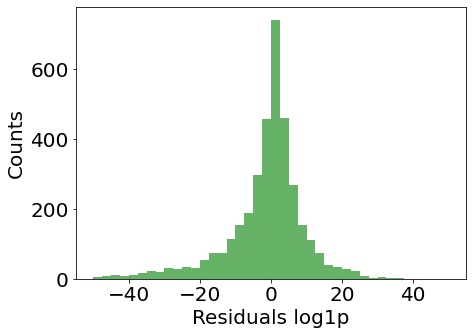

In [16]:
fig, axs = plt.subplots(figsize=(7, 5))
axs.hist(residual_log, bins=40, range=[-50,50], density=False, alpha=0.6, color='g')
# axs.set_title('Log1p-scale', fontsize=16)
axs.set_ylabel('Counts', fontsize=20)
axs.set_xlabel('Residuals log1p', fontsize=20)
axs.tick_params(axis='both', labelsize=20)
plt.show()

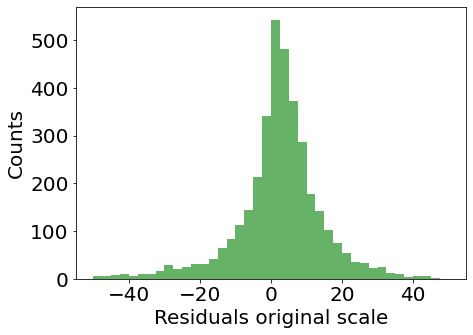

In [17]:
fig, axs = plt.subplots(figsize=(7, 5))
axs.hist(residual_ori, bins=40, range=[-50,50],density=False, alpha=0.6, color='g')
# axs.set_title('Log1p-scale', fontsize=16)
axs.set_ylabel('Counts', fontsize=20)
axs.set_xlabel('Residuals original scale', fontsize=20)
axs.tick_params(axis='both', labelsize=20)
plt.show()

In [11]:
a = ['property', 'MAE, model ori, in ori', 'MAE, model log, in ori','MAPE, model ori, in ori', 'MAPE, model log, in ori',
 'CCC, model ori, in log', 'CCC, model log, in log','R2, model ori, in log', 'R2, model log, in log']
results[a]

,property,"MAE, model ori, in ori","MAE, model log, in ori","MAPE, model ori, in ori","MAPE, model log, in ori","CCC, model ori, in log","CCC, model log, in log","R2, model ori, in log","R2, model log, in log"
0,ocd,9.966648,8.786355,1.011276e+00,5.630426e-01,0.738028,0.816590,0.578563,0.696025
1,oc,30.662366,25.343917,2.850709e+13,1.636184e+13,0.641528,0.720326,0.356600,0.569800
2,bulk_density,0.185163,0.193495,3.841617e-01,3.745237e-01,0.781765,0.775138,0.652300,0.633292
3,ph_cacl2,0.678355,0.681064,1.286533e-01,1.267884e-01,0.739037,0.742131,0.600472,0.601712
4,ph_h2o,0.626711,0.629525,1.050952e-01,1.041307e-01,0.747885,0.749893,0.611097,0.612666
5,N,3.995941,3.580936,2.649458e+13,7.808710e+12,0.743915,0.809342,0.504849,0.689071
6,caco3,53.044330,45.838322,4.270415e+16,5.076170e+15,0.448514,0.650308,-0.146632,0.503620
7,K,117.327333,98.801460,1.892943e+15,1.091052e+15,0.345777,0.476686,0.081917,0.319874
8,EC,14.953083,12.016172,1.142393e+00,6.274242e-01,0.498428,0.561168,0.180164,0.395286
9,P,19.017191,16.911096,6.227318e+15,2.804877e+15,0.247121,0.416914,0.019262,0.269395


In [ ]:
# # comparison plots for predictions from different models

# plt.figure(figsize=(12, 8))
# # plt.hexbin(train[prop], pred[f'{prop}_original']-pred[f'{prop}_log1p'], label='backtransformed before averaging', gridsize=gridsize, mincnt=5, extent=[0,80,0,80])
# plt.hexbin(pred[f'{prop}_original'], np.expm1(pred[f'{prop}_log1p_backtransformed']), gridsize=gridsize, mincnt=1, bins='log') #,vmax=6000, label='backtransformed before averaging'
# plt.plot([0,600],[0,600],label='1:1')
# # plt.scatter(train[tgt], pred[f'{prop}_log1p_backtransformed'], label='direct averaging', alpha=0.5)

# # Add title and labels
# plt.title('Predicted SOC comparison', fontsize=16)
# plt.xlabel('Original model', fontsize=14)
# plt.ylabel('Backtransformed-log1p model', fontsize=14)
# plt.legend(fontsize=14)
# plt.colorbar()


# plt.figure(figsize=(12, 8))
# # plt.hexbin(train[prop], pred[f'{prop}_original']-pred[f'{prop}_log1p'], label='backtransformed before averaging', gridsize=gridsize, mincnt=5, extent=[0,80,0,80])
# plt.hexbin(pred[f'{prop}_original'], np.expm1(pred[f'{prop}_log1p']), gridsize=gridsize, mincnt=1, bins='log') #,vmax=6000, label='backtransformed before averaging'
# plt.plot([0,600],[0,600],label='1:1')
# # plt.scatter(train[tgt], pred[f'{prop}_log1p_backtransformed'], label='direct averaging', alpha=0.5)

# # Add title and labels
# plt.title('Predicted SOC comparison', fontsize=16)
# plt.xlabel('Original model', fontsize=14)
# plt.ylabel('log1p model', fontsize=14)
# plt.legend(fontsize=14)
# plt.colorbar()


# plt.figure(figsize=(12, 8))
# # plt.hexbin(train[prop], pred[f'{prop}_original']-pred[f'{prop}_log1p'], label='backtransformed before averaging', gridsize=gridsize, mincnt=5, extent=[0,80,0,80])
# plt.hexbin(pred[f'{prop}_original'], np.expm1(pred[f'{prop}_log1p']), gridsize=gridsize, mincnt=1, bins='log') #,vmax=6000, label='backtransformed before averaging'
# plt.plot([0,600],[0,600],label='1:1')
# # plt.scatter(train[tgt], pred[f'{prop}_log1p_backtransformed'], label='direct averaging', alpha=0.5)

# # Add title and labels
# plt.title('Predicted SOC comparison', fontsize=16)
# plt.xlabel('Predicted SOC by original model', fontsize=14)
# plt.ylabel('Predicted SOC by log1p model', fontsize=14)
# plt.legend(fontsize=14)
# plt.colorbar()